# Závislost přítomnosti poslanců na počasí

**Autor:** Šimon Schierreich (schiesim@fit.cvut.cz)

## Zadání

Zadání semestrální práce pochází od laboratoře [OpenDataLab](https://opendatalab.cz/) a firmy [Profinit](https://www.profinit.eu). Cílem projektu je potvrdit nebo vyvrátit vztah mezi přítomností poslanců v poslanecké sněmovně a počasím.

## Příprava dat

V první fázi projektu bylo třeba připravit data k analýze. Navzdory tomu, že zadání pochází od laboratoře otevřených dat, data potřebná k další práci bohužel tak uplně otevřená nejsou.

### Přítomnost poslanců

Poslanecká sněmovna bohužel data ve strojově čitelném formátu neposkytuje. Na stránkách instituce jsou ovšem dostupné informace o hlasování.

Někteří analytici se již stahováním dat o hlasováních poslanců z webové prezentace sněmovny zabývali, jejich projekty jsou bohužel neaktuální. Bylo tedy třeba vytvořit vlastní web-scraper, který z webové prezentace potřebná data vytáhne. Scraper je dostupný pod open-source licencí na [GitHubu](https://github.com/opendatalabcz/weather-mp-dependency).

### Počasí

V Praze existují čtyři profesionální měřící stanice a Klementinum, které sice není považován za profesionální, nicméně je nejblíže poslanecké sněmovně. Všech pět stanic je ve správě ČHMÚ, který se vydání dat o počasí brání.

Ze stránek hydrometerologického ústavu jsou dostupná archivní data vždy za předchozí rok. Ze stránek National Centers for Environmental Information je pak možné stáhnout data o počasí již za předchozí den. 

Všechny uvedené zdroje ovšem publikují pouze informace o teplotě a srážkách, v rámci přípravy dat bylo tedy třeba informace o počasí ještě ručně doplnit o délku slunečního svitu. Ta byla ručně získána z portálu https://in-pocasi.cz, jelikož jsou publikována ve formě grafů.

## Analýza dat o poslancích

Po získání dat o přítomnosti poslanců byla provedena základní analýza docházky poslanců v poslanecké sněmovně. Jako první došlo k 

![title](img/picture.png)


In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import datetime
import scipy.stats as sstats
import scipy.spatial.distance as sdist

data = pd.read_csv( 'weather.csv' )
davg = pd.read_csv( 'weather_avg.csv', index_col="month" )
dmem = pd.read_csv( 'psp_data.csv', header = None, names = [ "name", "vote", "sess_id", "vot_id", "year", "month" , "day", "hour", "minute" ] )

Nyní máme načtena data o počasí, můžeme pro každý model zjistit podíl hezkých dní. Začneme s modelem, který za hezký den považuje takový, kdy je nadprůměrná teplota a nejsou žádné srážky.

In [2]:
data[ 'pretty_m1' ] = data.apply( lambda row: int((davg.iloc[ int(row.month)-1 , 0 ] <= row.temp)*200), axis = 1 )
#data[ 'pretty_m1' ].value_counts().sort_index( ascending=False ).plot.pie( colors=[ "#0065bd", "#9b9b9b" ], autopct='%1.0f %%', figsize=(10,10) )
#data[ 'pretty_m1' ].value_counts().sort_index( ascending=False )

Druhý model považuje za hezký den takový, kdy je nadprůměrné množství slunečního svitu.

In [3]:
data[ 'pretty_m2' ] = data.apply( lambda row: int((davg.iloc[ int(row.month)-1, 1 ] <= row.ss)*200), axis=1 )
#data[ 'pretty_m2' ].value_counts().sort_index( ascending=False ).plot.pie(colors=[ "#0065bd", "#9b9b9b" ], autopct='%1.0f %%', figsize=(10,10))
#data[ 'pretty_m2' ].value_counts().sort_index( ascending=False )

Poslední model tak trochu kombinuje oba předchozí.

In [4]:
data[ 'pretty_m3' ] = data.apply( lambda row: int( (row.prcp <= 0.2) & (4 <= row.ss) & (davg.iloc[ int(row.month)-1 , 0 ] <= row.temp) )*200, axis=1 )
#data[ 'pretty_m3' ].value_counts().sort_index( ascending=False ).plot.pie(colors=[ "#0065bd", "#9b9b9b" ], autopct='%1.0f %%', figsize=(10,10))
#data[ 'pretty_m3' ].value_counts().sort_index( ascending=False )

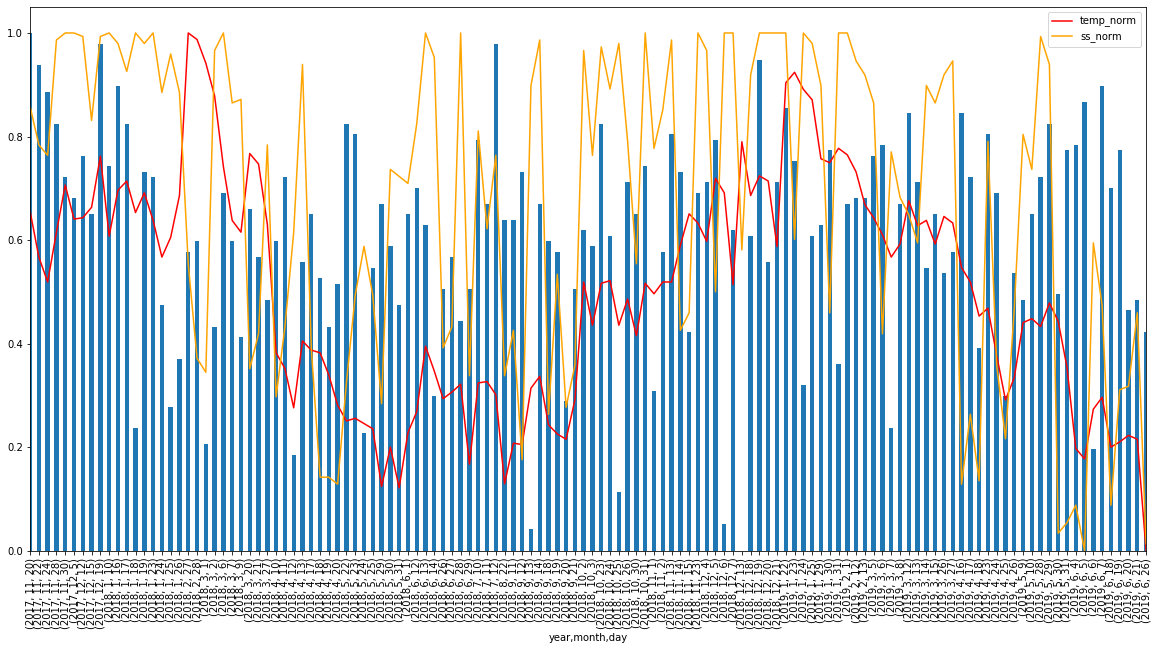

In [5]:
pres = dmem[ (dmem[ 'vote' ] == "A") | (dmem[ 'vote' ] == "N") | (dmem[ 'vote' ] == "Z") ].groupby( ["year", "month", "day", "vot_id"] ).size().groupby( [ "year", "month", "day" ] ).mean().apply(np.round).astype("int")

pres_n=((pres-pres.min())/(pres.max()-pres.min()))
ax = pres_n.plot( kind="bar", figsize=(20,10), rot=90 )

data[ "temp_norm" ] = 1-(data[ "temp" ]-data[ "temp" ].min())/(data[ "temp" ].max()-data["temp"].min())
data[ "ss_norm" ] = 1-(data[ "ss" ]-data[ "ss" ].min())/(data[ "ss" ].max()-data["ss"].min())
data[ [ "year", "month", "day", "temp_norm" ] ].plot.line( y = "temp_norm", ax = ax, color = "red", rot=90 )
data[ [ "year", "month", "day", "ss_norm" ] ].plot.line( y = "ss_norm", ax = ax, color = "orange", rot=90 )

In [6]:
data[ "pretty_m1" ] = (data[ "pretty_m1" ] / 200).astype( 'bool' )
data[ "pretty_m2" ] = (data[ "pretty_m2" ] / 200).astype( 'bool' )
data[ "pretty_m3" ] = (data[ "pretty_m3" ] / 200).astype( 'bool' )
print(sstats.pointbiserialr( pres.to_numpy(), data[ "pretty_m1" ].to_numpy() ))
print(sstats.pointbiserialr( pres.to_numpy(), data[ "pretty_m2" ].to_numpy() ))
print(sstats.pointbiserialr( pres.to_numpy(), data[ "pretty_m3" ].to_numpy() ))

PointbiserialrResult(correlation=-0.02033760771367183, pvalue=0.8197549557487434)
PointbiserialrResult(correlation=0.02062164844002808, pvalue=0.8172812477090992)
PointbiserialrResult(correlation=-0.07732430523083543, pvalue=0.3856447534472621)


In [8]:
pmem = dmem[ "name" ].sort_values().drop_duplicates()
mem_corr = { key : [] for key in pmem }

for name in pmem:
    df = dmem[ dmem[ "name" ] == name ][ [ "name", "year", "month", "day", "vote" ] ]
    if len(df) > 50:
        df[ "pres" ] = df[ "vote" ].apply( lambda vote : ( vote == "0" ) | (vote == "M") )
        del df[ "vote" ]
        df = df.groupby( [ "year", "month", "day" ] ).mean().apply( lambda row: (row > 0.5), axis = 1 )
        df = pd.merge( df, data[ [ "year", "month", "day", "pretty_m1", "pretty_m2", "pretty_m3" ] ], on = [ "year", "month", "day" ] )

        mem_corr[ name ] = [ sdist.rogerstanimoto( df[ "pres" ].to_numpy(), df[ "pretty_m1" ].to_numpy() ), sdist.rogerstanimoto( df[ "pres" ].to_numpy(), df[ "pretty_m2" ].to_numpy() ), sdist.rogerstanimoto( df[ "pres" ].to_numpy(), df[ "pretty_m3" ].to_numpy() ) ];

mdf = pd.DataFrame.from_dict( mem_corr, orient="index", columns=["M1","M2","M3"] )
print(mdf[["M1"]].sort_values( by = "M1").head(n=8).to_latex())
print(mdf[["M2"]].sort_values( by = "M2").head(n=8).to_latex())
print(mdf[["M3"]].sort_values( by = "M3").head(n=8).to_latex())

\begin{tabular}{lr}
\toprule
{} &        M1 \\
\midrule
Karel Schwarzenberg &  0.553672 \\
Martin Stropnický   &  0.584270 \\
Andrej Babiš        &  0.601093 \\
Jan Birke           &  0.631016 \\
Antonín Staněk      &  0.652632 \\
Jan Hamáček         &  0.659686 \\
Jana Levová         &  0.680412 \\
Milan Chovanec      &  0.683230 \\
\bottomrule
\end{tabular}

\begin{tabular}{lr}
\toprule
{} &        M2 \\
\midrule
Dan Ťok           &  0.567568 \\
Lubomír Volný     &  0.569832 \\
Stanislav Juránek &  0.577778 \\
Roman Onderka     &  0.577778 \\
Vojtěch Filip     &  0.585635 \\
Jiří Bláha        &  0.585635 \\
Marian Bojko      &  0.593407 \\
Jan Hamáček       &  0.593407 \\
\bottomrule
\end{tabular}

\begin{tabular}{lr}
\toprule
{} &        M3 \\
\midrule
Mikuláš Peksa      &  0.435897 \\
Lukáš Černohorský  &  0.439024 \\
Stanislav Juránek  &  0.439024 \\
Jan Schiller       &  0.448485 \\
Monika Oborná      &  0.448485 \\
Pavel Pustějovský  &  0.448485 \\
Roman Kubíček      &  0.448485